# Convert svg images to png images

In [4]:
import cairosvg

numbers = ['A'] + [str(num) for num in range(2, 11)] + ['J', 'Q', 'K']
colors = ['C', 'D', 'H', 'S']
input_cards = ['hd2_raw/{}{}.svg'.format(number, color) for color in colors for number in numbers]
numbers = [str(num) for num in range(1, 11)] + ['j', 'q', 'k']
colors = ['c', 'd', 'h', 's']
output_cards = ['hd2/{}{}.png'.format(color, number) for color in colors for number in numbers]
for input_card, output_card in zip(input_cards, output_cards):
    cairosvg.svg2png(url=input_card, write_to=output_card, scale = 6)

# Test the erosion filter and get a proper parameter

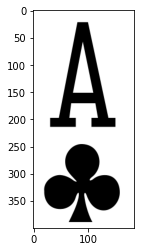

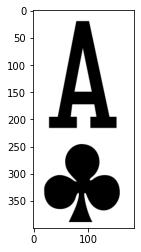

In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

def erosion(arr_3D, left = 0, top = 0, width = 185, height = 240, size = 1):
    
    # In numpy, first dim is height and second dim is width.
    ret = np.copy(arr_3D)
    arr_height, arr_width = arr_3D.shape[:2]
    for m in range(top, top + height):
        for n in range(left, left + width):
            for c in range(3):
                if not(size <= m < arr_height - size and size <= n < arr_width - size):
                    continue
                ret[m][n][c] = np.min(arr_3D[m-size:m+size+1, n-size:n+size+1, c])
    return ret

numbers = [str(num) for num in range(1, 11)] + ['j', 'q', 'k']
colors = ['c', 'd', 'h', 's']
input_cards = ['hd2/{}{}'.format(color, number) for color in colors for number in numbers]
for input_card in ['hd2/c1']:
    im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png'
    width, height = im.size  # (1345, 1876)

    # New output image
    bg_im = Image.open(input_card + '.png')
    white_im = Image.new(mode = "RGBA", color = "white", size = (1315, 1845))
    bg_im.paste(white_im, (15, 15))

    # Upper left symbol - a 185-width, 405-height box, resize to (235, 514)
    component = im.crop((15, 65, 200, 465))
    plt.figure()
    plt.imshow(np.asarray(component))
    
    component_np = np.array(component)
    component_np = erosion(component_np, left = 0, top = 0, width = 185, height = 240, size = 2)
    component = Image.fromarray(component_np, mode = "RGBA")
    
    plt.figure()
    plt.imshow(np.asarray(component))

# Detection key point and remove bias
The club, diamond, spade, heart symbols fall in [236\~257, 400] range, with height in [143, 164] range.  
The numbers fall in [7\~41, 199\~237] range, with height in [186, 203].  
So we normalize the height so that the numbers are in [0, 200] and the symbols in [250, 400] range.

<ipython-input-15-f37ec290a756>:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


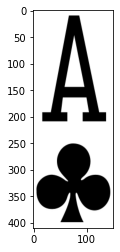

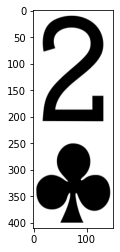

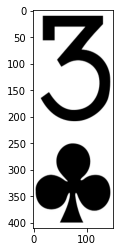

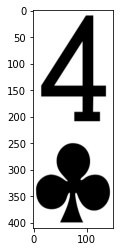

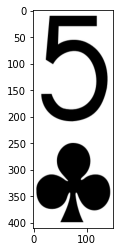

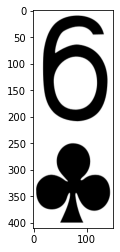

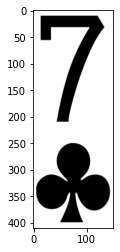

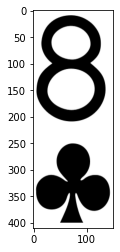

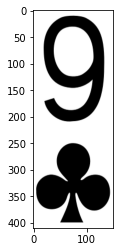

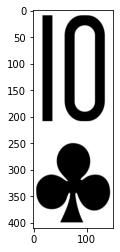

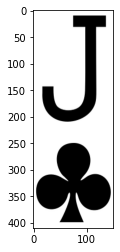

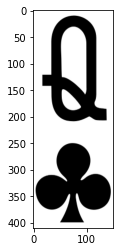

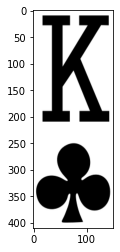

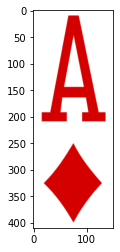

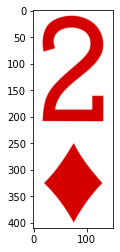

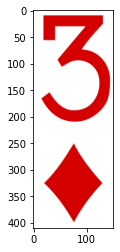

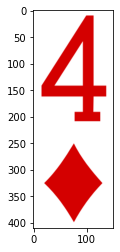

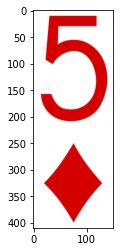

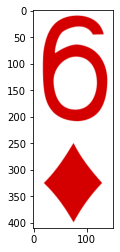

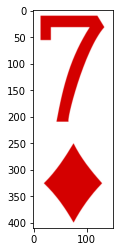

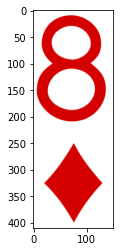

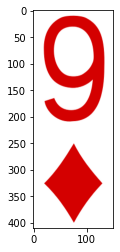

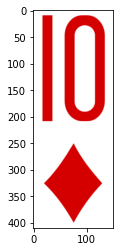

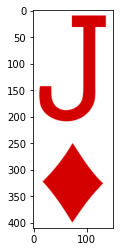

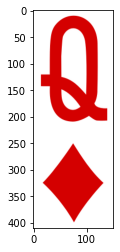

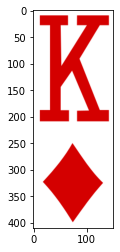

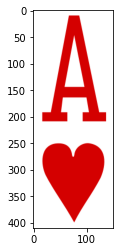

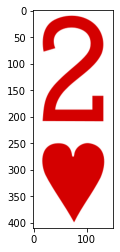

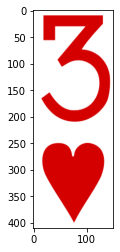

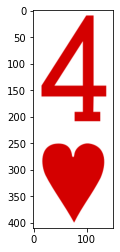

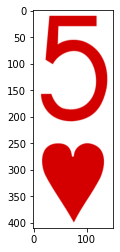

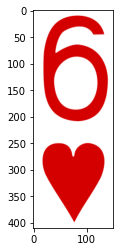

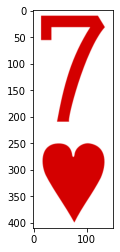

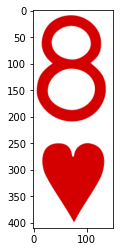

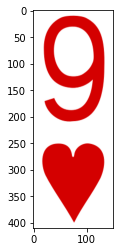

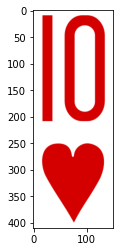

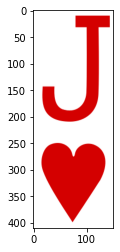

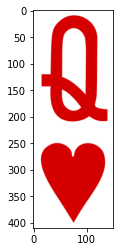

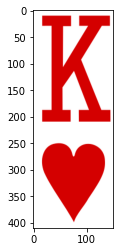

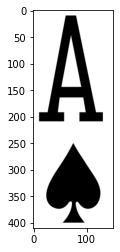

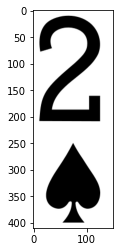

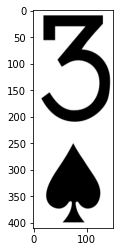

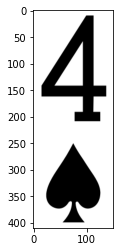

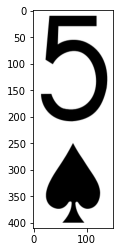

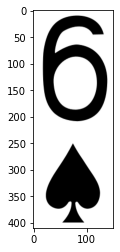

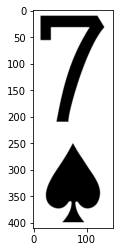

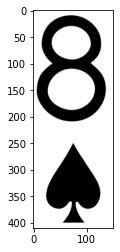

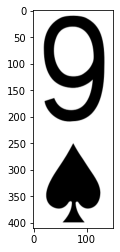

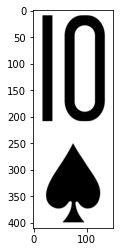

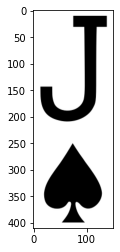

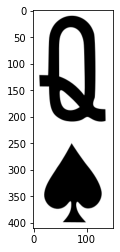

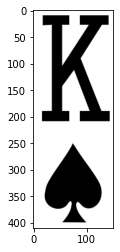

In [15]:
def kp_det(arr_3D, top = 240, height = 160):
    
    sum_byrow = np.sum(arr_3D[top:top+height, :, :], axis = (0, 2)) # length of width
    sym_left = min([idx for idx, num in enumerate(sum_byrow) if sum_byrow[idx] < sum_byrow[0]])
    sym_right = min([idx for idx, num in enumerate(sum_byrow) if sum_byrow[idx] == sum_byrow[0] and idx > sym_left])
    kp_left = (sym_left + sym_right) // 2
    
    sum_bycol = np.sum(arr_3D[:, :sym_right, :], axis = (1, 2)) # length of height
    kp_top = max([idx for idx, num in reversed(list(enumerate(sum_bycol))) if sum_bycol[idx] < sum_bycol[-1]])
    return kp_left, kp_top

def calibrate_component(component):
    
    # Calibrate the symbol and number in a component (width=150, height=410)
    sum_bycol = np.sum(component, axis = (1, 2)) # length of height
    sym_bottom2 = max([idx for idx, num in enumerate(sum_bycol) if num < sum_bycol[-1]])
    sym_top2 = max([idx for idx, num in enumerate(sum_bycol[:sym_bottom2]) if num == sum_bycol[-1]]) + 1
    sym_bottom1 = max([idx for idx, num in enumerate(sum_bycol[:sym_top2]) if num < sum_bycol[-1]])
    sym_top1 = max([idx for idx, num in enumerate(sum_bycol[:sym_bottom1]) if num == sum_bycol[-1]]) + 1
    sym1 = np.array(component)[sym_top1:sym_bottom1+1, :, :]
    sym1 = Image.fromarray(sym1, mode = "RGBA")
    sym1 = sym1.resize((sym1.size[0], 200), Image.ANTIALIAS)
    sym2 = np.array(component)[sym_top2:sym_bottom2+1, :, :]
    sym2 = Image.fromarray(sym2, mode = "RGBA")
    sym2 = sym2.resize((sym2.size[0], 150), Image.ANTIALIAS)
    component = Image.new(mode = "RGBA", color = "white", size = component.size)
    component.paste(sym1, (0, 10))  # left, top
    component.paste(sym2, (0, 250))  # left, top
    return component

numbers, colors = [str(num) for num in range(1, 11)] + ['j', 'q', 'k'], ['c', 'd', 'h', 's']
input_cards = ['hd2/{}{}'.format(color, number) for color in colors for number in numbers]
data = []
for input_card in input_cards:
    im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png'
    component = im.crop((25, 65, 190, 500)) # left1, top1, left2, top2. A 165-width, 435-height draft
    kp_left, kp_top = kp_det(np.array(component), top = 250, height = 185)
    ch_width_half, upper_room, lower_room = 75, 400, 10
    component = im.crop((25+kp_left-ch_width_half, 65+kp_top-upper_room, 
                         25+kp_left+ch_width_half, 65+kp_top+lower_room))
    component = calibrate_component(component)
    plt.figure()
    plt.imshow(np.asarray(component))
    #plt.plot([kp_left, kp_left], [0, 400])
    #plt.plot([0, 150], [kp_top, kp_top])
    #print(kp_left, kp_top)
    #break

# Edit on one image

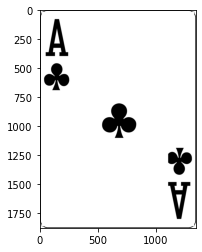

In [20]:
numbers, colors = [str(num) for num in range(1, 11)] + ['j', 'q', 'k'], ['c', 'd', 'h', 's']
input_cards = ['hd2/{}{}'.format(color, number) for color in colors for number in numbers]
for input_card in input_cards:
    im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png', (1345, 1876)
    width, height = im.size

    # New output image
    bg_im = Image.open(input_card + '.png')
    white_im = Image.new(mode = "RGBA", color = "white", size = (1345-30, 1876-30))
    bg_im.paste(white_im, (15, 15))

    # Upper left symbol - a 150-width, 410-height box, resize to (235, 642)
    component = im.crop((25, 65, 190, 500)) # left1, top1, left2, top2. A 165-width, 435-height draft
    kp_left, kp_top = kp_det(np.array(component), top = 250, height = 185)
    ch_width_half, upper_room, lower_room = 75, 400, 10
    component = im.crop((25+kp_left-ch_width_half, 65+kp_top-upper_room, 
                         25+kp_left+ch_width_half, 65+kp_top+lower_room))
    component = calibrate_component(component)
    component_np = erosion(np.array(component), left = 0, top = 0, width = 150, height = 240, size = 2)
    component = Image.fromarray(component_np, mode = "RGBA")
    component = component.resize((235, 642), Image.ANTIALIAS)
    bg_im.paste(component, (25, 65))
    component = component.rotate(angle = 180)
    bg_im.paste(component, (width-25-component.size[0], height-65-component.size[1]))
    
    # Middle symbox - a 975-width, 1645-height box, resize to (845, 1426)
    component = im.crop((185, 100, 1160, 1745))
    component = component.resize((845, 1426), Image.ANTIALIAS)
    bg_im.paste(component, (25+235, 225))

    plt.figure()
    plt.imshow(np.asarray(bg_im))
    #plt.imshow(np.asarray(component))
    #bg_im.save("past/tmp.png")
    break

# Bold + 142w + 28 distance

In [21]:
numbers, colors = [str(num) for num in range(1, 11)] + ['j', 'q', 'k'], ['c', 'd', 'h', 's']
input_cards = ['hd2/{}{}'.format(color, number) for color in colors for number in numbers]
output_cards = ['{}{}'.format(color, number) for color in colors for number in numbers]
suffixes = ["_142w_28d"]
whs = [(142, 192)]
for input_card, output_card in zip(input_cards, output_cards):
    im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png', (1345, 1876)
    width, height = im.size

    # New output image
    bg_im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png'
    white_im = Image.new(mode = "RGBA", color = "white", size = (1345-30, 1876-30))
    bg_im.paste(white_im, (15, 15))

    # Upper left symbol - a 150-width, 410-height box, resize to (235, 642)
    component = im.crop((25, 65, 190, 500)) # left1, top1, left2, top2. A 165-width, 435-height draft
    kp_left, kp_top = kp_det(np.array(component), top = 250, height = 185)
    ch_width_half, upper_room, lower_room = 75, 400, 10
    component = im.crop((25+kp_left-ch_width_half, 65+kp_top-upper_room, 
                         25+kp_left+ch_width_half, 65+kp_top+lower_room))
    component = calibrate_component(component)
    component_np = erosion(np.array(component), left = 0, top = 0, width = 150, height = 240, size = 2)
    component = Image.fromarray(component_np, mode = "RGBA")
    component = component.resize((235, 642), Image.ANTIALIAS)
    bg_im.paste(component, (25, 65))
    component = component.rotate(angle = 180)
    bg_im.paste(component, (width-25-component.size[0], height-65-component.size[1]))

    for (width, height), suffix in zip(whs, suffixes):
        bg_im2 = bg_im.resize((width, height), Image.ANTIALIAS)
        bg_im2.save(output_card + suffix + '.png')

# Bold + 142w + 38 distance

In [22]:
numbers, colors = [str(num) for num in range(1, 11)] + ['j', 'q', 'k'], ['c', 'd', 'h', 's']
input_cards = ['hd2/{}{}'.format(color, number) for color in colors for number in numbers]
output_cards = ['{}{}'.format(color, number) for color in colors for number in numbers]
suffixes = ["_142w_38d"]
whs = [(142, 192)]
for input_card, output_card in zip(input_cards, output_cards):
    im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png', (1345, 1876)
    width, height = im.size

    # New output image
    bg_im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png'
    white_im = Image.new(mode = "RGBA", color = "white", size = (1345-30, 1876-30))
    bg_im.paste(white_im, (15, 15))

    # Upper left symbol - a 150-width, 410-height box, resize to (330, 902)
    component = im.crop((25, 65, 190, 500)) # left1, top1, left2, top2. A 165-width, 435-height draft
    kp_left, kp_top = kp_det(np.array(component), top = 250, height = 185)
    ch_width_half, upper_room, lower_room = 75, 400, 10
    component = im.crop((25+kp_left-ch_width_half, 65+kp_top-upper_room, 
                         25+kp_left+ch_width_half, 65+kp_top+lower_room))
    component = calibrate_component(component)
    component_np = erosion(np.array(component), left = 0, top = 0, width = 150, height = 240, size = 2)
    component = Image.fromarray(component_np, mode = "RGBA")
    component = component.resize((330, 902), Image.ANTIALIAS)
    bg_im.paste(component, (25, 65))
    component = component.rotate(angle = 180)
    bg_im.paste(component, (width-25-component.size[0], height-65-component.size[1]))

    for (width, height), suffix in zip(whs, suffixes):
        bg_im2 = bg_im.resize((width, height), Image.ANTIALIAS)
        bg_im2.save(output_card + suffix + '.png')

# Bold + 106w + original distance

In [33]:
numbers, colors = [str(num) for num in range(1, 11)] + ['j', 'q', 'k'], ['c', 'd', 'h', 's']
input_cards = ['hd2/{}{}'.format(color, number) for color in colors for number in numbers]
output_cards = ['{}{}'.format(color, number) for color in colors for number in numbers]
suffixes = ["_106w"]
whs = [(106, 143)]
for input_card, output_card in zip(input_cards, output_cards):
    im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png', (1345, 1876)
    width, height = im.size

    # New output image
    bg_im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png'
    white_im = Image.new(mode = "RGBA", color = "white", size = (1345-30, 1876-30))
    bg_im.paste(white_im, (15, 15))

    # Upper left symbol - a 150-width, 410-height box, resize to (225, 615)
    component = im.crop((25, 65, 190, 500)) # left1, top1, left2, top2. A 165-width, 435-height draft
    kp_left, kp_top = kp_det(np.array(component), top = 250, height = 185)
    ch_width_half, upper_room, lower_room = 75, 400, 10
    component = im.crop((25+kp_left-ch_width_half, 65+kp_top-upper_room, 
                         25+kp_left+ch_width_half, 65+kp_top+lower_room))
    component = calibrate_component(component)
    component_np = erosion(np.array(component), left = 0, top = 0, width = 150, height = 240, size = 2)
    component = Image.fromarray(component_np, mode = "RGBA")
    component = component.resize((225, 615), Image.ANTIALIAS)
    bg_im.paste(component, (25, 65))
    component = component.rotate(angle = 180)
    bg_im.paste(component, (width-25-component.size[0], height-65-component.size[1]))

    # Middle symbox - a 975-width, 1676-height box, resize to 845-width, 1452-height
    component = im.crop((185, 100, 1160, 1776))
    component = component.resize((845, 1452), Image.ANTIALIAS)
    bg_im.paste(component, (250, 212))
    
    for (width, height), suffix in zip(whs, suffixes):
        bg_im2 = bg_im.resize((width, height), Image.ANTIALIAS)
        bg_im2.save(output_card + suffix + '.png')

# Convert cat images

In [3]:
from PIL import Image
intputs = ["Milli_424w.png", "Milli_424w.png", "Milli_424w.png", 
           "Andy_576w.png", "Andy_576w.png", "Andy_576w.png"]
outputs = ["Milli3_142w_28d.png", "Milli3_142w_38d.png", "Milli3_106w.png",
           "Andy3_142w_28d.png", "Andy3_142w_38d.png", "Andy3_106w.png"]
whs = [(142, 192), (142, 192), (106, 143), (142, 192), (142, 192), (106, 143)]
for intput, output, wh in zip(intputs, outputs, whs):
    im = Image.open(intput)  # e.g., 'Milli_424w.png', (424, 573)
    im = im.resize(wh, Image.ANTIALIAS)
    im.save(output)

# [Outdated] Thin character & 38-distance

In [27]:
# Original image
numbers = [str(num) for num in range(1, 11)] + ['j', 'q', 'k']
colors = ['c', 'd', 'h', 's']
input_cards = ['hd2/{}{}'.format(color, number) for color in colors for number in numbers]
output_cards = ['{}{}'.format(color, number) for color in colors for number in numbers]
suffixes = ["_106w_38d", "_142w_38d"]
whs = [(106, 143), (142, 192)]
for input_card, output_card in zip(input_cards, output_cards):
    im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png'
    width, height = im.size  # (1345, 1876)

    # New output image
    bg_im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png'
    white_im = Image.new(mode = "RGBA", color = "white", size = (1315, 1845))
    bg_im.paste(white_im, (15, 15))

    # Upper left symbol - a 185-width, 405-height box, resize to (330, 722)
    component = im.crop((15, 65, 200, 465))
    component = component.resize((330, 722), Image.ANTIALIAS)
    bg_im.paste(component, (15, 65))
    
    # Middle symbox - a 975-width, 1645-height box, resize to (625, 1054)
    component = im.crop((185, 100, 1160, 1745))
    component = component.resize((625, 1054), Image.ANTIALIAS)
    bg_im.paste(component, (360, 411))
    
    # lower right symbol - a 185-width, 405-height box, resize to (330, 722)
    component = im.crop((1145, 1411, 1330, 1811))  # (-15, -65)
    component = component.resize((330, 722), Image.ANTIALIAS)
    bg_im.paste(component, (width-15-330, height-65-722))

    for (width, height), suffix in zip(whs, suffixes):
        bg_im2 = bg_im.resize((width, height), Image.ANTIALIAS)
        bg_im2.save(output_card + suffix + '.png')

# [Outdated] Thin charactor and 28 distance

In [50]:
# Original image
numbers = [str(num) for num in range(1, 11)] + ['j', 'q', 'k']
colors = ['c', 'd', 'h', 's']
input_cards = ['hd2/{}{}'.format(color, number) for color in colors for number in numbers]
output_cards = ['{}{}'.format(color, number) for color in colors for number in numbers]
suffixes = ["", "_106w_28d", "_large"]
whs = [(71, 96), (106, 143), (142, 192)]
for input_card, output_card in zip(input_cards, output_cards):
    im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png'
    width, height = im.size  # (1345, 1876)

    # New output image
    bg_im = Image.open(input_card + '.png')  # e.g., 'hd2/dk.png'
    white_im = Image.new(mode = "RGBA", color = "white", size = (1315, 1845))
    bg_im.paste(white_im, (15, 15))

    # Upper left symbol - a 185-width, 405-height box, resize to (235, 514)
    component = im.crop((15, 65, 200, 465))
    component = component.resize((235, 514), Image.ANTIALIAS)
    bg_im.paste(component, (15, 65))

    # Middle symbox - a 975-width, 1645-height box, resize to (845, 1426)
    component = im.crop((185, 100, 1160, 1745))
    component = component.resize((845, 1426), Image.ANTIALIAS)
    bg_im.paste(component, (25+235, 225))

    # lower right symbol - a 185-width, 405-height box, resize to (235, 514)
    component = im.crop((1145, 1411, 1330, 1811))  # (-15, -65), 1145, 1411, 1330, 1811)
    component = component.resize((235, 514), Image.ANTIALIAS)
    bg_im.paste(component, (width-15-235, height-65-514))

    for (width, height), suffix in zip(whs, suffixes):
        bg_im2 = bg_im.resize((width, height), Image.ANTIALIAS)
        bg_im2.save(output_card + suffix + '.png')